# Predicting the value of car sales project

Nicholas Stollmann <br>

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time as tm
import random

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso,RidgeCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.svm import SVR

from scipy import stats

In [2]:
cars_full = pd.read_csv("autos.csv",encoding = "ISO-8859-1")
cars_full.head().T

,0,1,2,3,4
dateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20
name,Golf_3_1.6,A5_Sportback_2.7_Tdi,"Jeep_Grand_Cherokee_""Overland""",GOLF_4_1_4__3TÜRER,Skoda_Fabia_1.4_TDI_PD_Classic
seller,privat,privat,privat,privat,privat
offerType,Angebot,Angebot,Angebot,Angebot,Angebot
price,480,18300,9800,1500,3600
abtest,test,test,test,test,test
vehicleType,NaN,coupe,suv,kleinwagen,kleinwagen
yearOfRegistration,1993,2011,2004,2001,2008
gearbox,manuell,manuell,automatik,manuell,manuell
powerPS,0,190,163,75,69


In [3]:
cars_full.describe()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


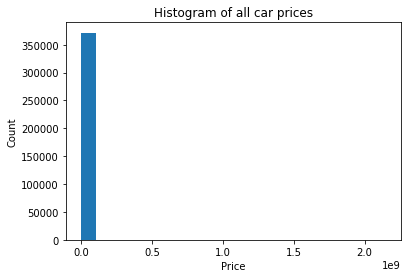

In [4]:
plt.hist(cars_full.price,bins = 20)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Histogram of all car prices")
plt.show()

## Initial Data cleaning

- Reducing the data set by removing all cars with price >= 80,000 and with price = 0 to remove outliers
- Dropping useless column ("nrOfPictures")
- Translating some words from German to english

In [5]:
#remove cases where price > $80000 and where price is < $0
cars = cars_full[(cars_full["price"] <= 80000) & (cars_full["price"] > 0)]

#dropping "nrOfPictures" column as it has no information
cars = cars.drop(["nrOfPictures"], axis = 1)

#german to english translations of some words
cars = cars.replace({"seller": {"privat":"private","gewerblich":"commercial"},
                     "offerType":{"Angebot":"Offer","Gesuch":"Request"},
                     "vehicleType":{"kleinwagen":"small_car","cabrio":"convertible","kombi":"station_wagon","andere":"other"},
                    "gearbox":{"manuell":"manual","automatik":"automatic"},
                    "fuelType":{"benzin":"petrol","andere":"other","elektro":"electronic"},
                    "notRepairedDamage":{"ja":"yes", "nein":"no"}})



print("Total number of data entries: {}.".format(len(cars_full)))
print("Total number of data entries without cars > $80,000: {}.".format(len(cars)))
print("Number of data entries lost by removing those values: {}.".format(len(cars_full)-len(cars)))

Total number of data entries: 371528.
Total number of data entries without cars > $80,000: 360170.
Number of data entries lost by removing those values: 11358.


Histogram of price after removal of outliers

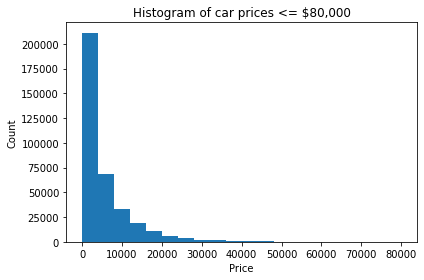

In [6]:
plt.hist(cars.price,bins = 20)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Histogram of car prices <= $80,000")
plt.tight_layout()
plt.show()

Count of the values in different categories

In [7]:
from collections import Counter


print(Counter(cars["offerType"]).keys())
print(Counter(cars["offerType"]).values())

print(' ')

print(Counter(cars["seller"]).keys())
print(Counter(cars["seller"]).values())
print(' ')

print(Counter(cars["vehicleType"]).keys())
print(Counter(cars["vehicleType"]).values())
print(' ')

print(Counter(cars["gearbox"]).keys())
print(Counter(cars["gearbox"]).values())
print(' ')

print(Counter(cars["fuelType"]).keys())
print(Counter(cars["fuelType"]).values())
print(' ')

print(Counter(cars["notRepairedDamage"]).keys())
print(Counter(cars["notRepairedDamage"]).values())


dict_keys(['Offer', 'Request'])
dict_values([360164, 6])
 
dict_keys(['private', 'commercial'])
dict_values([360167, 3])
 
dict_keys([nan, 'coupe', 'suv', 'small_car', 'limousine', 'convertible', 'bus', 'station_wagon', 'other'])
dict_values([34077, 18251, 14475, 78200, 93793, 22381, 29760, 66085, 3148])
 
dict_keys(['manual', 'automatic', nan])
dict_values([267060, 75463, 17647])
 
dict_keys(['petrol', 'diesel', nan, 'lpg', 'other', 'hybrid', 'cng', 'electronic'])
dict_values([217825, 106159, 29859, 5233, 172, 269, 560, 93])
 
dict_keys([nan, 'yes', 'no'])
dict_values([66696, 34264, 259210])


Analysis of type of vehicle data

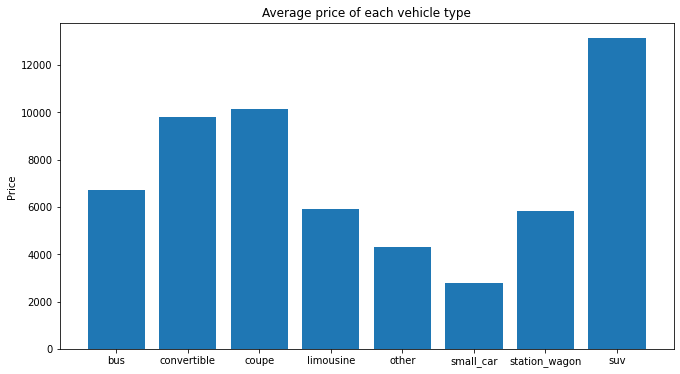

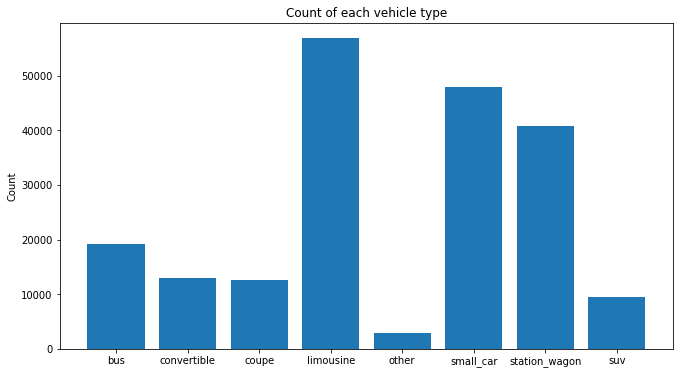

In [8]:
#Group by vehicle type to see average price of each vehicle
price_of_cars = cars.groupby(["vehicleType"])["price"].mean().reset_index()

#Group to find the number of each vehicle
type_of_cars = cars.groupby(["vehicleType"])["name"].nunique().reset_index()

figure(num = None, figsize = (11,6))
plt.bar("vehicleType", "price", data = price_of_cars)
plt.ylabel("Price")
plt.title("Average price of each vehicle type")
plt.show()

type_of_cars.columns = ["Type of Vehicle", "Count"]
figure(num = None, figsize = (11,6))
plt.bar("Type of Vehicle", "Count", data = type_of_cars)
plt.ylabel("Count")
plt.title("Count of each vehicle type")
plt.show()

### Part 2: Changing the data to prepare for modelling

In [9]:
data = cars

print(data.columns)
data.head()

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'postalCode', 'lastSeen'],
      dtype='object')


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,private,Offer,480,test,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,private,Offer,18300,test,coupe,2011,manual,190,NaN,125000,5,diesel,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",private,Offer,9800,test,suv,2004,automatic,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,private,Offer,1500,test,small_car,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,private,Offer,3600,test,small_car,2008,manual,69,fabia,90000,7,diesel,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


### Further datacleaning and preprocessing

In [10]:
data.notRepairedDamage.value_counts()

no     259210
yes     34264
Name: notRepairedDamage, dtype: int64

In [11]:
#All these columns are useless for the modelling aspect of the project

data.drop(["dateCrawled","name","seller","offerType","postalCode", "lastSeen","abtest"], axis = 1,inplace = True)


data.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,5,diesel,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,automatic,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00
3,1500,small_car,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small_car,2008,manual,69,fabia,90000,7,diesel,skoda,no,2016-03-31 00:00:00


In [12]:
#Change the data column to a datetime object
data.dateCreated = pd.to_datetime(data["dateCreated"])
data.dtypes

price                           int64
vehicleType                    object
yearOfRegistration              int64
gearbox                        object
powerPS                         int64
model                          object
kilometer                       int64
monthOfRegistration             int64
fuelType                       object
brand                          object
notRepairedDamage              object
dateCreated            datetime64[ns]
dtype: object

Creating a new column in the dataframe describing car age when sold

In [13]:
data["year_created"] = pd.DatetimeIndex(data["dateCreated"]).year

data["car_age"] = data["year_created"] - data["yearOfRegistration"]

data.drop(["dateCreated","yearOfRegistration"], axis = 1, inplace = True)
data.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,year_created,car_age
0,480,NaN,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016,23
1,18300,coupe,manual,190,NaN,125000,5,diesel,audi,yes,2016,5
2,9800,suv,automatic,163,grand,125000,8,diesel,jeep,NaN,2016,12
3,1500,small_car,manual,75,golf,150000,6,petrol,volkswagen,no,2016,15
4,3600,small_car,manual,69,fabia,90000,7,diesel,skoda,no,2016,8


Check for missing values

Then drop all rows with missing values as it is a small percentage of the total and imputation is not an option for these categorical variables.

In [14]:
print(data.shape)
print(data.isna().sum())
print("All missing data is coming from categorical data so imputing the missing values is not an appropriate option. So we remove all na values.")
data.dropna(inplace=True)
print(data.isna().sum())
data.head()

(360170, 12)
price                      0
vehicleType            34077
gearbox                17647
powerPS                    0
model                  18149
kilometer                  0
monthOfRegistration        0
fuelType               29859
brand                      0
notRepairedDamage      66696
year_created               0
car_age                    0
dtype: int64
All missing data is coming from categorical data so imputing the missing values is not an appropriate option. So we remove all na values.
price                  0
vehicleType            0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
year_created           0
car_age                0
dtype: int64


,price,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,year_created,car_age
3,1500,small_car,manual,75,golf,150000,6,petrol,volkswagen,no,2016,15
4,3600,small_car,manual,69,fabia,90000,7,diesel,skoda,no,2016,8
5,650,limousine,manual,102,3er,150000,10,petrol,bmw,yes,2016,21
6,2200,convertible,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016,12
10,2000,limousine,manual,105,3_reihe,150000,12,petrol,mazda,no,2016,12


Data is now cleaned however we need to change string data to numerical

In [15]:
data["vehicleType"] = data["vehicleType"].astype('category') #Change vehicle type to categorical

In [16]:
data["vehicle_type_cat"] = data["vehicleType"].cat.codes #Make it numerical
data.head()

,price,vehicleType,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,year_created,car_age,vehicle_type_cat
3,1500,small_car,manual,75,golf,150000,6,petrol,volkswagen,no,2016,15,5
4,3600,small_car,manual,69,fabia,90000,7,diesel,skoda,no,2016,8,5
5,650,limousine,manual,102,3er,150000,10,petrol,bmw,yes,2016,21,3
6,2200,convertible,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016,12,1
10,2000,limousine,manual,105,3_reihe,150000,12,petrol,mazda,no,2016,12,3


In [17]:
print(data.model.value_counts()) #model column has too many variables, so it is dropped

data.drop(["model"], axis = 1, inplace = True)

golf               20607
andere             19951
3er                15392
polo                8674
corsa               8151
                   ...  
elefantino             5
rangerover             4
serie_3                3
samara                 3
discovery_sport        1
Name: model, Length: 250, dtype: int64


In [18]:
print(data.brand.nunique())
data["brand"] = data["brand"].astype('category')
data["brand_cat"] = data['brand'].cat.codes
data.head(2)
#The brand column is changed to a categorical variable

39


,price,vehicleType,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,year_created,car_age,vehicle_type_cat,brand_cat
3,1500,small_car,manual,75,150000,6,petrol,volkswagen,no,2016,15,5,37
4,3600,small_car,manual,69,90000,7,diesel,skoda,no,2016,8,5,31


Make remaining categorical values to numbers

In [19]:
print(data.gearbox.nunique())
print(data.fuelType.nunique())
print(data.notRepairedDamage.nunique())

data["gearbox"] = data["gearbox"].astype('category')
data["gearbox_cat"] = data['gearbox'].cat.codes

data["fuelType"] = data["fuelType"].astype('category')
data["fuelType_cat"] = data['fuelType'].cat.codes

data["notRepairedDamage"] = data["notRepairedDamage"].astype('category')
data["notRepairedDamage_cat"] = data['notRepairedDamage'].cat.codes

data.head(2)

2
7
2


,price,vehicleType,gearbox,powerPS,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,year_created,car_age,vehicle_type_cat,brand_cat,gearbox_cat,fuelType_cat,notRepairedDamage_cat
3,1500,small_car,manual,75,150000,6,petrol,volkswagen,no,2016,15,5,37,1,6,0
4,3600,small_car,manual,69,90000,7,diesel,skoda,no,2016,8,5,31,1,1,0


In [20]:
# Drop remaining string columns & Year_created
data.drop(["vehicleType","gearbox","fuelType","brand","notRepairedDamage", "year_created"],axis = 1, inplace = True)

In [21]:
print(data.dtypes)

data = data[["price","powerPS","kilometer","car_age","monthOfRegistration","vehicle_type_cat","brand_cat",
            "gearbox_cat","fuelType_cat","notRepairedDamage_cat"]]
data.head(5)

price                    int64
powerPS                  int64
kilometer                int64
monthOfRegistration      int64
car_age                  int64
vehicle_type_cat          int8
brand_cat                 int8
gearbox_cat               int8
fuelType_cat              int8
notRepairedDamage_cat     int8
dtype: object


,price,powerPS,kilometer,car_age,monthOfRegistration,vehicle_type_cat,brand_cat,gearbox_cat,fuelType_cat,notRepairedDamage_cat
3,1500,75,150000,15,6,5,37,1,6,0
4,3600,69,90000,8,7,5,31,1,1,0
5,650,102,150000,21,10,3,2,1,6,1
6,2200,109,150000,12,8,1,25,1,6,0
10,2000,105,150000,12,12,3,19,1,6,0


Data is now cleaned and ready for the model.

Split the data into train,validation and test sets

In [22]:
#Separate in X - all the independent variables and Y - the dependent variable
X = data[["powerPS","kilometer","car_age","monthOfRegistration","vehicle_type_cat","brand_cat",
            "gearbox_cat","fuelType_cat","notRepairedDamage_cat"]].values

y = data[["price"]].values.ravel()

In [23]:
X1, X_test, y1, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1) #Test set 20%

#X1, y1 are placeholders for the next split
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size = 0.26, random_state = 1) #Validation set 20% of TOTAL

print(f"X_train shape: {X_train.shape}"),
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (152274, 9)
X_val shape: (53502, 9)
X_test shape: (51444, 9)
y_train shape: (152274,)
y_val shape: (53502,)
y_test shape: (51444,)


#### Separate categorical and continuous variables for scaling
* We only scale the continuous variables

In [24]:
X_train_cont = X_train[:,0:3] #Take continuous variables to scale
X_train_cat = X_train[:,3:] #Take categorical variables as they will not be scaled

X_val_cont = X_val[:,0:3]#Take continuous variables to scale
X_val_cat = X_val[:,3:]#Take categorical variables as they will not be scaled

X_test_cont = X_test[:,0:3]#Take continuous variables to scale
X_test_cat = X_test[:,3:]#Take categorical variables as they will not be scaled


Scale all the continuous variables so they are on the same scale

In [25]:
sc = StandardScaler()

X_train_cont = sc.fit_transform(X_train_cont)
X_val_cont = sc.transform(X_val_cont)
X_test_cont = sc.transform(X_test_cont)


Re-combine all the X datasets into 1

In [26]:
X_train = np.concatenate((X_train_cont,X_train_cat), axis = 1)

X_val = np.concatenate((X_val_cont,X_val_cat), axis = 1)

X_test = np.concatenate((X_test_cont,X_test_cat), axis = 1)


In [27]:
print(f"X_train shape: {X_train.shape}"),
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (152274, 9)
X_val shape: (53502, 9)
X_test shape: (51444, 9)
y_train shape: (152274,)
y_val shape: (53502,)
y_test shape: (51444,)


Correlation Matrix of variables used in the analysis
* There are some variables that correlate somewhat, however this is expected based on the type of data

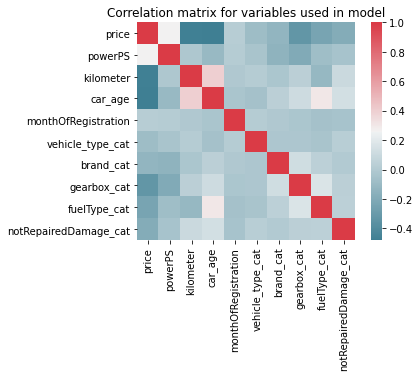

In [28]:
X_train_corr = data.corr()

sns.heatmap(X_train_corr, mask=np.zeros_like(X_train_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.title("Correlation matrix for variables used in model")
plt.show()

## Linear Regression Models

Simple linear regression model

In [50]:
lm_model = LinearRegression(n_jobs = -1)
lm_model.fit(X_train,y_train)

y_pred = lm_model.predict(X_val)

lm_model.score(X_val,y_val)
print("Linear model coefficients of determination(R^2):{:.4f}.".format(lm_model.score(X_val,y_val)))
print("Linear model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))


Linear model coefficients of determination(R^2):0.4455.
Linear model root mean squared error:  5807.646674686456


Ridge Regression linear model

In [108]:
ridg = Ridge()
ridg.fit(X_train,y_train)

y_pred = ridg.predict(X_val)

print("Ridge linear model coefficients of determination(R^2):{:.4f}.".format(ridg.score(X_val,y_val)))
print("Ridge linear model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))


Ridge linear model coefficients of determination(R^2):0.4455.
Ridge linear model root mean squared error:  5807.647266453065


Lasso Regression linear model

In [109]:
lass = Lasso()
lass.fit(X_train,y_train)

y_pred = lass.predict(X_val)

print("Lasso linear model coefficients of determination(R^2):{:.4f}.".format(lass.score(X_val,y_val)))
print("Lasso linear model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))

Lasso linear model coefficients of determination(R^2):0.4455.
Lasso linear model root mean squared error:  5807.590189230923


Elastic Net (Linear regression using L1 and L2 as regularizers)

In [110]:
enm = ElasticNet()
enm.fit(X_train,y_train)

y_pred = enm.predict(X_val)

enm.score(X_val,y_val)
print("Elastic Net model coefficients of determination(R^2):{:.4f}.".format(enm.score(X_val,y_val)))
print("Elastic Net model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))

Elastic Net model coefficients of determination(R^2):0.4012.
Elastic Net model root mean squared error:  6034.955684028203


In [111]:
ridgCV = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
ridgCV.fit(X_train,y_train)

y_pred = ridgCV.predict(X_val)

print("Ridge linear model coefficients of determination(R^2):{:.4f}.".format(ridgCV.score(X_val,y_val)))
print("Ridge linear model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))


Ridge linear model coefficients of determination(R^2):0.4455.
Ridge linear model root mean squared error:  5807.647266372454


Calculate the final R^2 score for the linear regression model using the test set

In [51]:
## Final linear regression scores using the test set

y_pred = lm_model.predict(X_test)

print("Linear model coefficients of determination(R^2):{:.4f}.".format(lm_model.score(X_test,y_test)))
print("Linear model root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_test)))

lm_rmse = np.sqrt(metrics.mean_squared_error(y_pred,y_test))

Linear model coefficients of determination(R^2):0.4688.
Linear model root mean squared error:  5711.816599636984


### Cross validation for linear regression model

Combine the training set and the validation set to run 10-fold cross validation

In [40]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train_val = np.vstack((X_train,X_val))

y_train_val = np.concatenate((y_train,y_val))

print(f"X_train_val shape: {X_train_val.shape}")
print(f"y_train_val shape: {y_train_val.shape}")

X_train shape: (152274, 9)
X_val shape: (53502, 9)
y_train shape: (152274,)
y_val shape: (53502,)
X_train_val shape: (205776, 9)
y_train_val shape: (205776,)


Calculate the R^2 scores for 10-fold cross validation using the training set + validation set

In [44]:
cross_val_lm = LinearRegression()

cross_val_scores_lm = cross_val_score(cross_val_lm,X_train_val,y_train_val,cv = 10)
print(cross_val_scores_lm.mean())

0.4650689846216669


In [45]:
lm_result = {"Linear Model R^2 score": cross_val_scores_lm}

lm_result = pd.DataFrame(lm_result)
lm_result["Linear Model R^2 score"] = lm_result["Linear Model R^2 score"].apply(lambda x: round(x,2))
lm_result

,Linear Model R^2 score
0,0.47
1,0.48
2,0.50
3,0.45
4,0.47
5,0.49
6,0.46
7,0.42
8,0.47
9,0.44


## Decision Tree regressor

In [116]:
dt = DecisionTreeRegressor(random_state = 1)
dt.fit(X_train,y_train)

dt.score(X_val,y_val)


0.7965053989593075

In [117]:
y_pred = dt.predict(X_val)
print("Decision Tree root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))

Decision Tree root mean squared error:  3518.1471639761544


In [118]:
params = {"criterion":["mse","friedman_mse","mae"], "splitter":["best","random"], "max_depth":[4,6,8,10]}

dt_2 = GridSearchCV(DecisionTreeRegressor(), params)
dt_2.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [4, 6, 8, 10],
                         'splitter': ['best', 'random']})

In [119]:
print(dt_2.best_params_)

dt_2.score(X_val,y_val)

{'criterion': 'friedman_mse', 'max_depth': 10, 'splitter': 'best'}


0.8235997295271513

In [120]:
max_depth = range(9,15,1)
r_squared_val = []
r_squared_train = []


for depth in max_depth:
    tree = DecisionTreeRegressor(criterion = "friedman_mse", max_depth = depth,random_state = 1).fit(X_train,y_train)
    r_squared_train.append(tree.score(X_train,y_train))
    r_squared_val.append(tree.score(X_val,y_val))
    

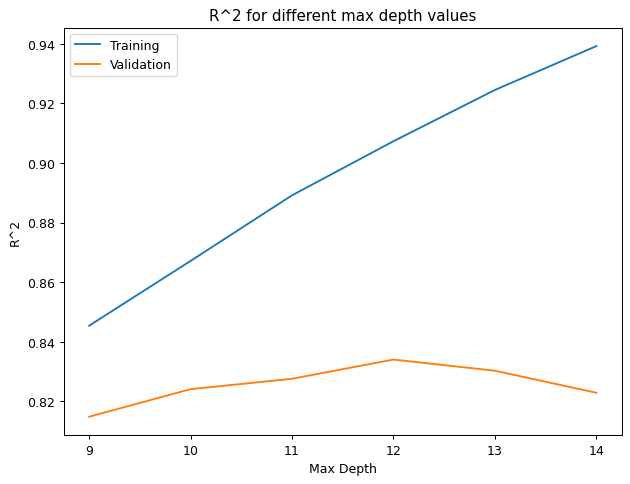

In [121]:
fig = plt.subplots(figsize=(8, 6), dpi=90)

plt.plot(max_depth,r_squared_train)
plt.plot(max_depth,r_squared_val)
plt.title("R^2 for different max depth values")
plt.xlabel("Max Depth")
plt.ylabel("R^2")
plt.legend(["Training","Validation"])
plt.show()

In [122]:
dt = DecisionTreeRegressor(criterion = "friedman_mse", max_depth = 12)
dt.fit(X_train,y_train)
dt.score(X_val,y_val)

0.8312870720974594

Calculate the coefficient of determination and the root mean squared error for the decision tree model using the test set. This is the result that will be used to compare models.

In [52]:
## Final decision tree scores using the test set
random.seed(999)

dt = DecisionTreeRegressor(criterion = "friedman_mse", max_depth = 12,random_state = 1).fit(X_train,y_train)

y_pred = dt.predict(X_test)

print("Decision Tree coefficients of determination(R^2):{:.4f}.".format(dt.score(X_test,y_test)))
print("Decision Tree root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_test)))

dt_rmse = np.sqrt(metrics.mean_squared_error(y_pred,y_test))

Decision Tree coefficients of determination(R^2):0.8331.
Decision Tree root mean squared error:  3201.1220083520584


#### Here is an example plot of a decision tree with reduce max_depth

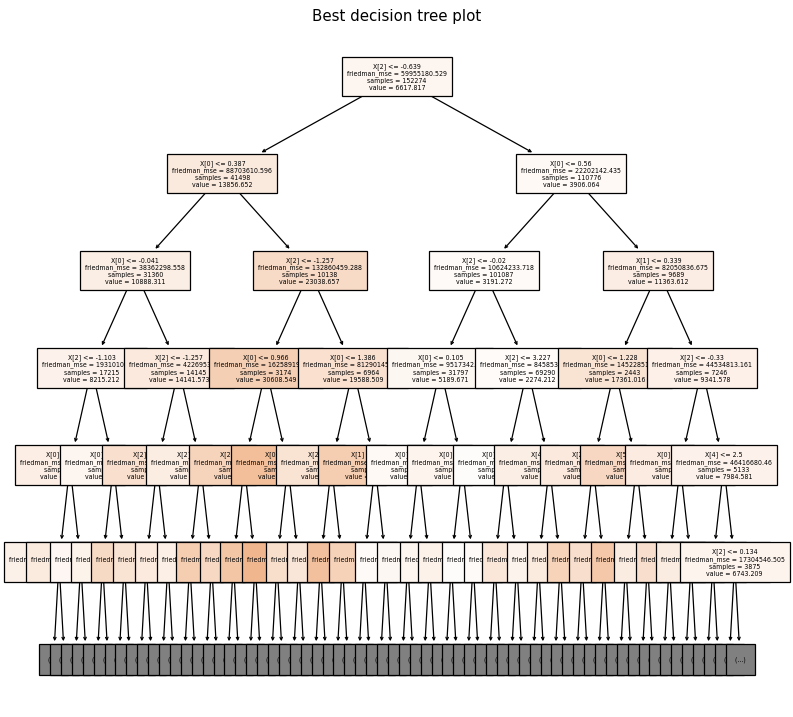

In [124]:
fig = plt.subplots(figsize=(10, 10), dpi=90)

plot_tree(dt, filled = True, fontsize = 5, max_depth = 5)
plt.title("Best decision tree plot")
plt.show()

#### Comparing decision tree to baseline linear regression model

In [56]:
cross_val_k_fold_dt = DecisionTreeRegressor(criterion = "friedman_mse", max_depth = 12,random_state = 1)

cross_val_scores_dt = cross_val_score(cross_val_k_fold_dt,X_train_val,y_train_val,cv = 10)
print(cross_val_scores_dt.mean())

0.8337371650669733


Conducted a two-sided t-test to see if the R^2 score of the decision tree is significantly better than the baseline liner regression model.

In [126]:
#T-test comparing decision tree vs linear model
stats.ttest_rel(cross_val_scores_lm,cross_val_scores_dt)

print("The result of the t-test with the null hypothesis suggesting the linear model and decision tree have the same R^2 is: {}.".
     format(stats.ttest_rel(cross_val_scores_lm,cross_val_scores_dt).pvalue*0.5))

print("\nWe therefore reject the null and say that the decision tree model with an R^2 average score of {:.2f} is significantly superior\nto the linear model with an R^2 average of {:.2f}.".
     format(cross_val_scores_dt.mean(),cross_val_scores_lm.mean()))



The result of the t-test with the null hypothesis suggesting the linear model and decision tree have the same R^2 is: 2.624185294015161e-13.

We therefore reject the null and say that the decision tree model with an R^2 average score of 0.83 is significantly superior
to the linear model with an R^2 average of 0.47.


In [127]:
dt_result = {"Decision Tree R^2 score": cross_val_scores_dt}

dt_result = pd.DataFrame(dt_result)
dt_result["Decision Tree R^2 score"] = dt_result["Decision Tree R^2 score"].apply(lambda x: round(x,2))
dt_result

,Decision Tree R^2 score
0,0.85
1,0.85
2,0.86
3,0.82
4,0.84
5,0.81
6,0.82
7,0.80
8,0.85
9,0.84


## Random Forest regressor

Run a forest regressor on the validation set

In [128]:
random_forest = RandomForestRegressor(n_jobs = -1,random_state = 1)
random_forest.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=1)

In [129]:
random_forest.score(X_val,y_val)

0.8786307238132549

In [130]:
y_pred = random_forest.predict(X_val)
print("Random Forest root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_val)))

Random Forest root mean squared error:  2717.0143822259056


Tuning to find the best number of trees to use:

In [131]:
n_estimators = range(5, 500, 50)
estimators_accuracies_val = []
estimators_accuracies_train = []

for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators = estimator,n_jobs = -1)
    rf.fit(X_train,y_train)
    estimators_accuracies_val.append(rf.score(X_val,y_val))
    estimators_accuracies_train.append(rf.score(X_train,y_train))
    
    

In [132]:
max_index = estimators_accuracies_val.index(max(estimators_accuracies_val))

best_number = n_estimators[max_index]

print("The best number of estimators to use for random forests is: {}.".format(best_number))

The best number of estimators to use for random forests is: 455.


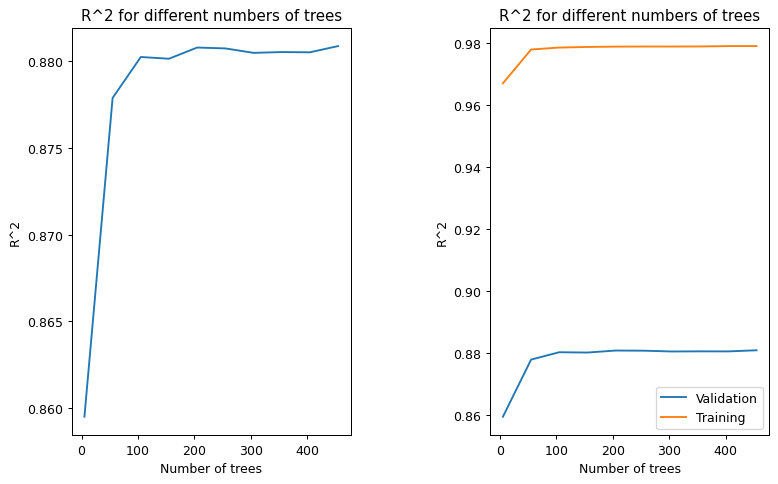

In [133]:
fig = plt.subplots(figsize=(10, 6), dpi=90)

plt.subplot(121)
plt.plot(n_estimators,estimators_accuracies_val)
plt.title("R^2 for different numbers of trees")
plt.xlabel("Number of trees")
plt.ylabel("R^2")


plt.subplot(122)
plt.plot(n_estimators,estimators_accuracies_val)
plt.plot(n_estimators,estimators_accuracies_train)
plt.title("R^2 for different numbers of trees")
plt.xlabel("Number of trees")
plt.ylabel("R^2")
plt.legend(["Validation","Training"])

plt.subplots_adjust(wspace = 0.5)
plt.show()

Text(0, 0.5, 'R^2')

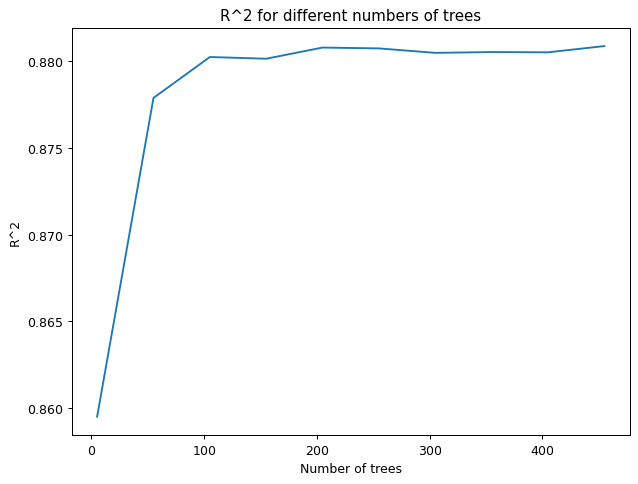

In [134]:
fig = plt.subplots(figsize=(8, 6), dpi=90)
plt.plot(n_estimators,estimators_accuracies_val)
plt.title("R^2 for different numbers of trees")
plt.xlabel("Number of trees")
plt.ylabel("R^2")

Tuning to find the best criterion method

In [29]:
criterions = ["mse","mae"]
criterions_accuracies = []

for criterion in criterions:
    rf = RandomForestRegressor(n_estimators =405,criterion = criterion ,n_jobs = -1)
    rf.fit(X_train,y_train)
    criterions_accuracies.append(rf.score(X_val,y_val)) 

In [30]:
print("The best criterion to use for this random forest is {} and it gives an R^2 of {:.2f}.".format(criterions[criterions_accuracies.index(max(criterions_accuracies))],max(criterions_accuracies)))

The best criterion to use for this random forest is mse and it gives an R^2 of 0.88.


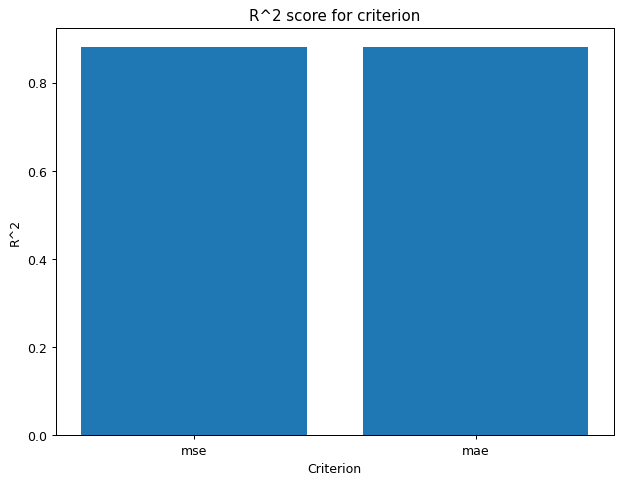

In [31]:
fig = plt.subplots(figsize=(8, 6), dpi=90)

plt.bar(criterions,criterions_accuracies)
plt.title("R^2 score for criterion")
plt.xlabel("Criterion")
plt.ylabel("R^2")
plt.show()

Tuning the find the bext number of features to use at every split

In [32]:
max_features = ["auto", "log2", 3,4,5]
max_features_accuracies = []

for feature in max_features:
    rf = RandomForestRegressor(n_estimators =405 ,n_jobs = -1,max_features = feature, random_state = 1)
    rf.fit(X_train,y_train)
    max_features_accuracies.append(rf.score(X_test,y_test)) 

In [33]:
print("The best distance measure to use for random forests is {} and it gives an R^2 of {:.2f}.".format(max_features[max_features_accuracies.index(max(max_features_accuracies))],max(max_features_accuracies)))

The best distance measure to use for random forests is log2 and it gives an R^2 of 0.90.


Finding the bext maximum depth

In [34]:
max_depth = range(10, 25, 1)
depth_accuracies_train = []
depth_accuracies_val = []


for depth in max_depth:
    rf = RandomForestRegressor(max_depth = depth,n_jobs = -1, random_state = 1)
    rf.fit(X_train,y_train)
    depth_accuracies_val.append(rf.score(X_val,y_val))
    depth_accuracies_train.append(rf.score(X_train,y_train))

In [35]:
max_index = depth_accuracies_val.index(max(depth_accuracies_val))

best_depth = max_depth[max_index]

print("The best number of estimators to use for random forests is: {}.".format(best_depth))

The best number of estimators to use for random forests is: 18.


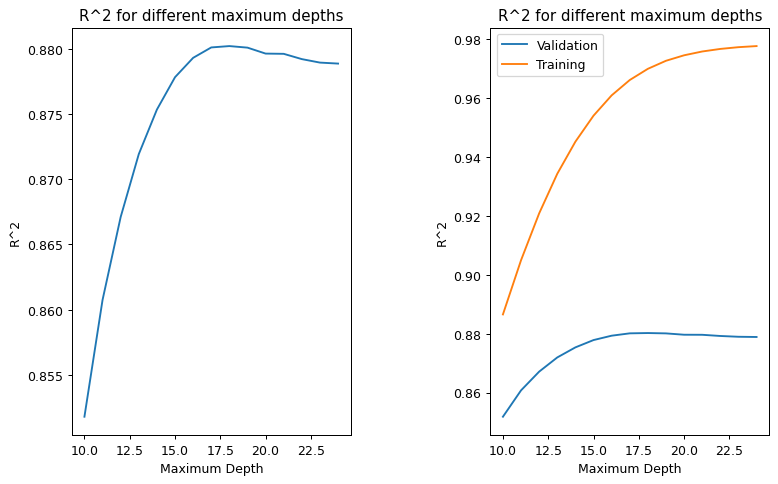

In [36]:
fig = plt.subplots(figsize=(10, 6), dpi=90)


plt.subplot(121)
plt.plot(max_depth,depth_accuracies_val)
plt.title("R^2 for different maximum depths")
plt.xlabel("Maximum Depth")
plt.ylabel("R^2")


plt.subplot(122)
plt.plot(max_depth,depth_accuracies_val)
plt.plot(max_depth,depth_accuracies_train)
plt.title("R^2 for different maximum depths")
plt.xlabel("Maximum Depth")
plt.ylabel("R^2")
plt.legend(["Validation","Training"])

plt.subplots_adjust(wspace = 0.5)
plt.show()


Using the best parameters for the final random forest model

In [37]:
rf_best = RandomForestRegressor(n_estimators = 405,max_depth = 18,max_features = 3,random_state = 1, n_jobs = -1)
rf_best.fit(X_train,y_train)
#random_forest_best.score(X_val,y_val)
#print("The R^2 of the best forest classifier on the validation set is: {:.2f}.".format(rf_best.score(X_val,y_val)))

RandomForestRegressor(max_depth=18, max_features=3, n_estimators=405, n_jobs=-1,
                      random_state=1)

Calculate the coefficient of determination and the root mean squared error for the decision tree model using the test set. This is the result that will be used to compare models.

In [38]:
## Final random forest scores using the test set

y_pred = rf_best.predict(X_test)

print("The R^2 of the best forest classifier on the validation set is:{:.4f}.".format(rf_best.score(X_test,y_test)))
print("Random Forest root mean squared error: ", np.sqrt(metrics.mean_squared_error(y_pred,y_test)))

rf_best_rmse = np.sqrt(metrics.mean_squared_error(y_pred,y_test))

The R^2 of the best forest classifier on the validation set is:0.8979.
Random Forest root mean squared error:  2503.9863397500944


#### Comparing random forest to baseline linear regression model

10-fold cross validation

In [41]:
start = tm.time()
cross_val_k_fold_rf = RandomForestRegressor(n_estimators = 405,max_depth = 18,max_features = 3,random_state = 1, n_jobs = -1)

cross_val_scores_rf = cross_val_score(cross_val_k_fold_rf,X_train_val,y_train_val,cv = 10) 
print(cross_val_scores_rf)

print(f"-------Running time------{tm.time()-start}")

[0.90586533 0.90212093 0.91279529 0.8899101  0.90207227 0.89485363
 0.89148964 0.88514735 0.89992237 0.88759196]
-------Running time------131.64301896095276


In [42]:
print(f"The average R^2 score from the 10-fold cross validation is {cross_val_scores_rf.mean()}.")

The average R^2 score from the 10-fold cross validation is 0.89717688824324.


In [46]:
#T-test comparing decision tree vs linear model

stats.ttest_rel(cross_val_scores_lm,cross_val_scores_rf)

print("The result of the t-test with the null hypothesis suggesting the linear model and a random forest regressor have the same R^2 is: {}.".
     format(stats.ttest_rel(cross_val_scores_lm,cross_val_scores_rf).pvalue*0.5))

print("\nWe therefore reject the null and say that the random forest model with an R^2 average score of {:.2f} is significantly superior\nto the linear model with an R^2 average of {:.2f}.".
     format(cross_val_scores_rf.mean(),cross_val_scores_lm.mean()))


The result of the t-test with the null hypothesis suggesting the linear model and a random forest regressor have the same R^2 is: 2.1329313133397467e-14.

We therefore reject the null and say that the random forest model with an R^2 average score of 0.90 is significantly superior
to the linear model with an R^2 average of 0.47.


In [47]:
rf_result = {"Random Forest R^2 score": cross_val_scores_rf}

rf_result = pd.DataFrame(rf_result)
rf_result["Random Forest R^2 score"] = rf_result["Random Forest R^2 score"].apply(lambda x: round(x,2))
rf_result

,Random Forest R^2 score
0,0.91
1,0.90
2,0.91
3,0.89
4,0.90
5,0.89
6,0.89
7,0.89
8,0.90
9,0.89


In [53]:
linear_r_squared = lm_model.score(X_test,y_test)

decision_tree_r_squared = dt.score(X_test,y_test)

random_forest_r_squared = rf_best.score(X_test,y_test)

scores = {"Model":["Linear Regression Model", "Decision Tree Model","Random Forest Model"],
         "R^2":[round(linear_r_squared,2),round(decision_tree_r_squared,2),round(random_forest_r_squared,2)],
         "Root mean squared error":[round(lm_rmse,2),round(dt_rmse,2),round(rf_best_rmse,2)]}

results = pd.DataFrame(scores)
results

,Model,R^2,Root mean squared error
0,Linear Regression Model,0.47,5711.82
1,Decision Tree Model,0.83,3201.12
2,Random Forest Model,0.90,2503.99


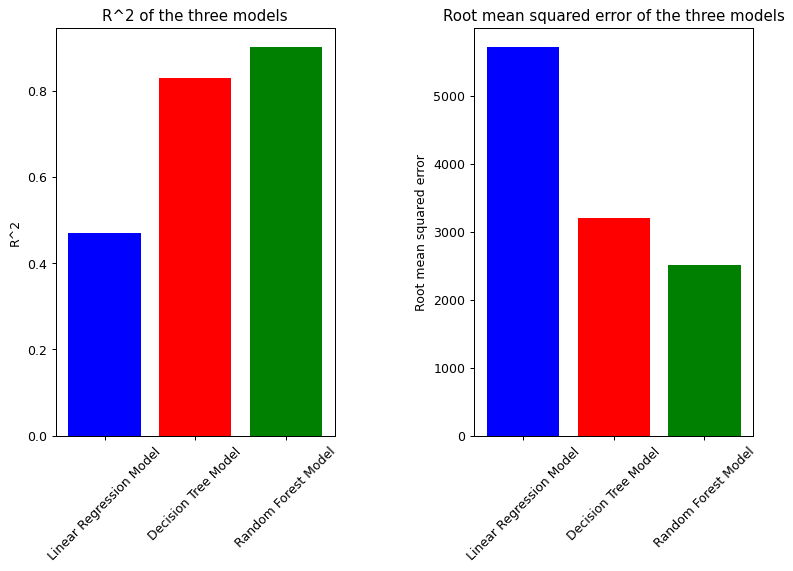

In [54]:
fig = plt.subplots(figsize=(10, 6), dpi=90)

plt.subplot(121)
plt.bar(results.Model,results['R^2'], color = ["blue","red","green"])
plt.title("R^2 of the three models")
plt.ylabel("R^2")
plt.xticks(rotation = 45)

plt.subplot(122)
plt.bar(results.Model,results["Root mean squared error"], color = ["blue","red","green"])
plt.title("Root mean squared error of the three models")
plt.ylabel("Root mean squared error")
plt.xticks(rotation = 45)



plt.subplots_adjust(wspace = 0.5)
plt.show()

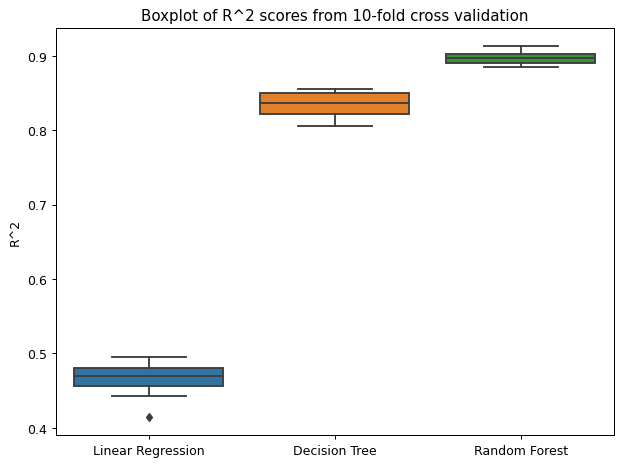

In [57]:
fig = plt.subplots(figsize=(8, 6), dpi=90)


sns.boxplot(data = [cross_val_scores_lm,cross_val_scores_dt,cross_val_scores_rf])
plt.xticks(plt.xticks()[0],["Linear Regression","Decision Tree","Random Forest"])
plt.ylabel("R^2")
plt.title("Boxplot of R^2 scores from 10-fold cross validation")
plt.show()


## Neural Network using tensorflow

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [31]:
print(X_train.shape, X_val.shape, X_test.shape)

(152274, 9) (53502, 9) (51444, 9)


In [32]:
tf.config.list_physical_devices('GPU')
##Check GPU is working

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [45]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(128, activation = "relu", input_shape = (X_train.shape[1],)))
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dense(1))
    
    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.001),
                 loss = "mse",
                 metrics = ["mse"])
    return model
    
model = build_model()

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 182,657
Trainable params: 182,657
Non-trainable params: 0
________________________________________________

In [47]:
EPOCHS = 50
batch_size = 100


history = model.fit(X_train,y_train,epochs = EPOCHS, batch_size = batch_size, 
                   validation_data = (X_val, y_val))

Epoch 1/50
1523/1523 [==============================] - 8s 5ms/step - loss: 39719608.3990 - mse: 39719608.4042 - val_loss: 17036650.0000 - val_mse: 17036650.0000.4197 - mse
Epoch 2/50
1523/1523 [==============================] - 8s 5ms/step - loss: 13536301.9738 - mse: 13536302.0190 - val_loss: 12265061.0000 - val_mse: 12265061.0000 mse: - ETA: 3s - loss: 13763145. - ETA: 2s 
Epoch 3/50
1523/1523 [==============================] - 7s 5ms/step - loss: 12172718.0564 - mse: 12172718.0564 - val_loss: 11626866.0000 - val_mse: 11626866.0000: 
Epoch 4/50
1523/1523 [==============================] - 8s 5ms/step - loss: 11382913.7598 - mse: 11382913.1575 - val_loss: 12244693.0000 - val_mse: 12244693.0000
Epoch 5/50
1523/1523 [==============================] - 7s 5ms/step - loss: 11029013.8104 - mse: 11029013.8104 - val_loss: 11353664.0000 - val_mse: 11353664.0000
Epoch 6/50
1523/1523 [==============================] - 8s 5ms/step - loss: 10615690.6857 - mse: 10615690.6867 - val_loss: 12966701.0

In [48]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mse,val_loss,val_mse
0,31861116.0,31861116.0,17036650.0,17036650.0
1,12912701.0,12912701.0,12265061.0,12265061.0
2,11691452.0,11691452.0,11626866.0,11626866.0
3,11160893.0,11160892.0,12244693.0,12244693.0
4,10820426.0,10820426.0,11353664.0,11353664.0


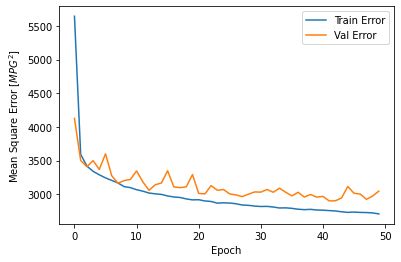

In [49]:
def plot_history(history):
    
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    
    plt.plot(hist["epoch"], np.sqrt(hist["mse"]), label = "Train Error")
    plt.plot(hist["epoch"], np.sqrt(hist["val_mse"]), label = "Val Error")
    plt.legend()
    #plt.ylim([0,20])
    
plot_history(history)

In [50]:
from sklearn.metrics import mean_squared_error

predictions_tf = model.predict(X_test)

print(f"The root mean squared error over the test set is {np.sqrt(mean_squared_error(predictions_tf, y_test))}.")

The root mean squared error over the test set is 2882.205025355644.


Using a tensorflow Neural Network showed no improved on the root mean squared error in comparison to the best previous model (Random Forest).

### XGBoost

In [42]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [31]:
dtrain = xgb.DMatrix(X_train,label = y_train)
dval = xgb.DMatrix(X_val, label = y_val)
dtest = xgb.DMatrix(X_test, label = y_test)

In [47]:
xgb.XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [32]:
params = {"max_depth" : range(1,22,3), "n_estimators" : range(1,250,50)}



In [33]:
xgb = xgb.XGBRegressor()

In [34]:
%%time
clf = GridSearchCV(xgb, params, n_jobs = -1).fit(X_train,y_train)

Wall time: 16min 33s


In [35]:
clf.score(X_test,y_test)

0.8956600346109197

In [38]:
xgb_preds = clf.predict(X_test)

In [39]:
print("The R^2 of the best forest classifier on the validation set is:{:.4f}.".format(clf.score(X_test,y_test)))
print("Random Forest root mean squared error: ", np.sqrt(metrics.mean_squared_error(xgb_preds,y_test)))


The R^2 of the best forest classifier on the validation set is:0.8957.
Random Forest root mean squared error:  2531.414094132426


In [40]:
clf.best_params_

{'max_depth': 7, 'n_estimators': 201}

In [49]:
xgb2 = xgb.XGBRegressor(max_depth = 7, n_estimators = 201, n_jobs = -1)

In [50]:
params2 = {"eta" : [0.05,0.1,0.3],
           "max_depth" : range(1,11,2),
           "subsample":[0.5,0.7,1]}


In [51]:
%%time
clf2 = GridSearchCV(xgb2, params2, n_jobs = -1, verbose = 1).fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Wall time: 7min 42s


In [52]:
clf2.best_params_

{'eta': 0.1, 'max_depth': 9, 'subsample': 1}

In [54]:
print("The R^2 of the best XGBoost classifier on the validation set is:{:.4f}.".format(clf2.score(X_test,y_test)))
print("XGBoost root mean squared error: ", np.sqrt(metrics.mean_squared_error(clf2.predict(X_test),y_test)))

The R^2 of the best XGBoost classifier on the validation set is:0.8989.
XGBoost root mean squared error:  2491.8773408368006


The XGBoost model is the best model and has shown a reduced root mean squared error, with it being 2492.